# Check Loglikelihood model selection behaviour

We need to verify if the LL is correlated with the Mixture model summary stats fits. If they are not, something went wrong somewhere, or the parameters are interacting in a weird way that we need to understand...

Performed by *generator_LLcheck_random_fitexperimentallt_sigmaxMratiosigmaoutput_121015.py*


In [93]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [94]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from experimentlauncher import ExperimentLauncher
from dataio import DataIO
import plots_experimental_data

# import matplotlib.animation as plt_anim
from mpl_toolkits.mplot3d import Axes3D

import re
import inspect
import imp

import utils
# import submitpbs
import load_experimental_data

In [95]:
%run reloader_LLcheck_random_fitexperimentallt_sigmaxMratiosigmaoutput_121015.py

Reloader data generated from  generator_LLcheck_random_fitexperimentallt_sigmaxMratiosigmaoutput_121015.py
Running  /nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/reloader_LLcheck_random_fitexperimentallt_sigmaxMratiosigmaoutput_121015.py
Arguments: []

        Reload outputs run with the automatic parameter generator for PBS

        Should handle random sampling of the parameter space.
    
Reloader data generated from  generator_LLcheck_random_fitexperimentallt_sigmaxMratiosigmaoutput_121015.py
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLcheck_random_fitexperimentallt_bays09_sigmaxMratiosigmaoutput_repetitions3_121015/LLcheck_random_fitexperimentallt_bays09_sigmaxMratiosigmaoutput_repetitions3_121015-launcher_do_fitexperiment_allmetrics-4af3c05d-4f1c-4f9b-bff9-f23d7088e4cb.npy
0.00%, -- left - 13.10 19:19
M 389.00, ratio_conj 0.93, sigmax 0.43, sigma_output 1.37
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/L

In [96]:
#### SETUP
#
plots_bestfits = True
plots_scatter3d = False

savefigs = True

# dataio = DataIO(output_folder=generator_module.pbs_submission_infos['simul_out_dir'] + '/outputs/', label='global_' + dataset_infos['save_output_filename'])

#
#### /SETUP

In [97]:
# Extract data
result_ll_sum_flat = np.array(data_pbs.dict_arrays['result_ll_sum']['results_flat'])
result_ll90_sum_flat = np.array(data_pbs.dict_arrays['result_ll90_sum']['results_flat'])
result_precision_flat = np.array(data_pbs.dict_arrays['result_precision']['results_flat'])
result_em_fits_flat = np.array(data_pbs.dict_arrays['result_em_fits']['results_flat'])
result_emfit_mse_flat = np.array(data_pbs.dict_arrays['result_emfit_mse']['results_flat'])
result_emfit_mixt_kl_flat = np.array(data_pbs.dict_arrays['result_emfit_mixt_kl']['results_flat'])
result_fi_theo_flat = np.array(data_pbs.dict_arrays['result_fi_theo']['results_flat'])
result_fi_theocov_flat = np.array(data_pbs.dict_arrays['result_fi_theocov']['results_flat'])

result_parameters_flat = np.array(data_pbs.dict_arrays['result_ll_sum']['parameters_flat'])
all_repeats_completed = data_pbs.dict_arrays['result_ll_sum']['repeats_completed']

all_args_arr = np.array(data_pbs.loaded_data['args_list'])

M_space = data_pbs.loaded_data['parameters_uniques']['M']
ratio_conj_space = data_pbs.loaded_data['parameters_uniques']['ratio_conj']
sigmax_space = data_pbs.loaded_data['parameters_uniques']['sigmax']
sigmaoutput_space = data_pbs.loaded_data['parameters_uniques']['sigma_output']

num_repetitions = generator_module.num_repetitions
parameter_names_sorted = data_pbs.dataset_infos['parameters']

In [98]:
def str_best_params(best_i, result_dist_to_use):
    return '[{:3d}] '.format(best_ind) + ' '.join(["%s %.4f" % (parameter_names_sorted[param_i], result_parameters_flat[best_i, param_i]) 
                     for param_i in xrange(len(parameter_names_sorted))]) + ' >> %f' % result_dist_to_use[best_i]


In [99]:
# Reload experimental data
experiment_id = all_args_arr[0]['experiment_id']
data_groundtruth = load_experimental_data.load_data(experiment_id=experiment_id)

reloaded mixture model from cache /nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/experimental_data/Bays2009/em_bays_allitems.pickle
reloaded collapsed mixture model from cache /nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/experimental_data/Bays2009/collapsed_em_bays.pickle


In [100]:
## Filter everything with repeats_completed == num_repet
filter_data = all_repeats_completed == num_repetitions - 1

result_parameters_flat = result_parameters_flat[filter_data]
all_args_arr = all_args_arr[filter_data]
all_repeats_completed = all_repeats_completed[filter_data]

print "Size post-filter: ", result_parameters_flat.shape[0]


Size post-filter:  398


In [101]:
# Compute lots of averages over the repetitions
result_ll_sum_avg = utils.nanmean(result_ll_sum_flat, axis=-1)
result_ll90_sum_avg = utils.nanmean(result_ll90_sum_flat, axis=-1)
result_em_fits_avg = utils.nanmean(result_em_fits_flat, axis=-1)
result_emfit_mse_avg = utils.nanmean(result_emfit_mse_flat, axis=-1)
result_emfit_mixt_kl_avg = utils.nanmean(result_emfit_mixt_kl_flat, axis=-1)

# Compute best results
result_dist_emfit_mse = np.nansum(np.nansum(result_emfit_mse_avg, axis=-1), axis=-1)
result_dist_emfit_kl = np.nansum(result_emfit_mixt_kl_avg, axis=-1)
result_dist_nll = np.nansum(-result_ll_sum_avg, axis=-1)
result_dist_nll90 = np.nansum(-result_ll90_sum_avg, axis=-1)

# Get the best fitting parameters
best_params_em = np.argsort(result_dist_emfit_mse)
best_params_kl = np.argsort(result_dist_emfit_kl)
best_params_ll = np.argsort(result_dist_nll)
best_params_ll90 = np.argsort(result_dist_nll90)

## -> Pandas now

In [102]:
df_all_fits = pd.DataFrame.from_items([('M', result_parameters_flat[:, 0]),
                             ('ratio_conj', result_parameters_flat[:, 1]),
                             ('sigmax', result_parameters_flat[:, 2]),
                             ('sigma_output', result_parameters_flat[:, 3]),
                             ('dist_emfit_mse', result_dist_emfit_mse),
                             ('dist_emfit_kl', result_dist_emfit_kl),
                             ('dist_nll', result_dist_nll),
                             ('dist_nll90', result_dist_nll90),
                            ])
df_all_fits = df_all_fits.assign(dist_emfit_mse_log = lambda x: np.log(x['dist_emfit_mse']),
                                   dist_nll_log = lambda x: np.log(x['dist_nll'])
                                  )

In [103]:
# Filter rows where LL > cutoff value
LL_min_cutoff = 3000
df_best_fits = df_all_fits[df_all_fits.dist_nll < LL_min_cutoff]

In [104]:
## Correlations
df_best_fits.corr()

,M,ratio_conj,sigmax,sigma_output,dist_emfit_mse,dist_emfit_kl,dist_nll,dist_nll90,dist_emfit_mse_log,dist_nll_log
M,1.000000,0.165987,0.118417,-0.002542,-0.107484,-0.091298,-0.062738,-0.196642,-0.098242,-0.060547
ratio_conj,0.165987,1.000000,0.117166,0.165171,0.214445,-0.097086,-0.387901,-0.195590,0.147961,-0.387976
sigmax,0.118417,0.117166,1.000000,-0.290344,-0.087961,-0.474243,0.363189,0.331478,-0.065593,0.363596
sigma_output,-0.002542,0.165171,-0.290344,1.000000,0.856343,0.109535,0.229514,0.596991,0.707017,0.224025
dist_emfit_mse,-0.107484,0.214445,-0.087961,0.856343,1.000000,0.012114,0.118329,0.587078,0.923192,0.114351
dist_emfit_kl,-0.091298,-0.097086,-0.474243,0.109535,0.012114,1.000000,0.036649,-0.068781,0.083113,0.035788
dist_nll,-0.062738,-0.387901,0.363189,0.229514,0.118329,0.036649,1.000000,0.801092,0.002778,0.998823
dist_nll90,-0.196642,-0.195590,0.331478,0.596991,0.587078,-0.068781,0.801092,1.000000,0.463636,0.798563
dist_emfit_mse_log,-0.098242,0.147961,-0.065593,0.707017,0.923192,0.083113,0.002778,0.463636,1.000000,-0.002286
dist_nll_log,-0.060547,-0.387976,0.363596,0.224025,0.114351,0.035788,0.998823,0.798563,-0.002286,1.000000


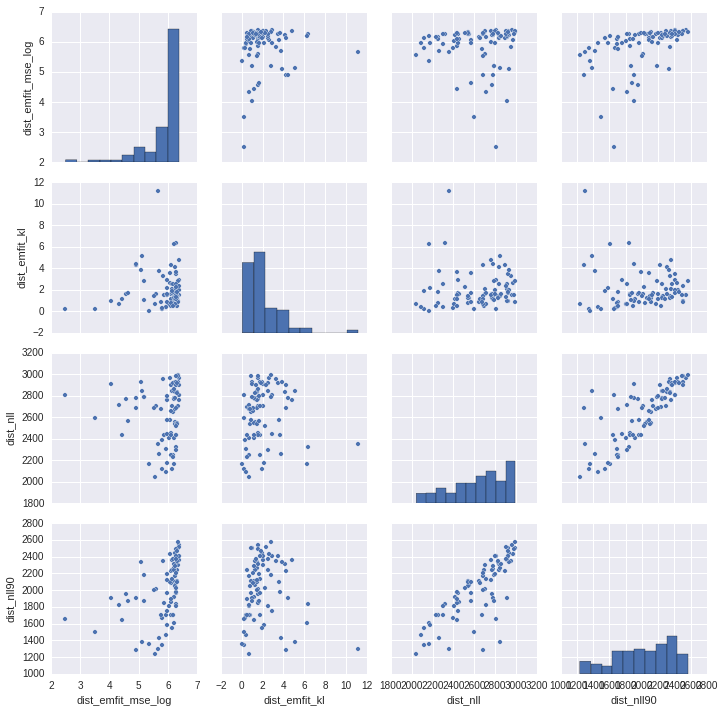

In [105]:
# Cross-correlation plots
sns.pairplot(df_best_fits,
             x_vars=['dist_emfit_mse_log', 'dist_emfit_kl', 'dist_nll', 'dist_nll90'],
             y_vars=['dist_emfit_mse_log', 'dist_emfit_kl', 'dist_nll', 'dist_nll90']
            )

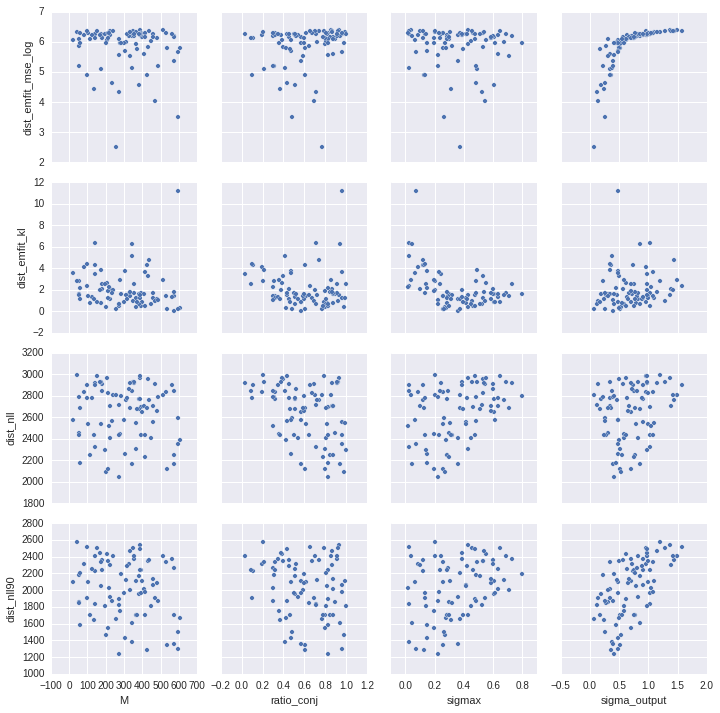

In [106]:
# Check parameters effects
sns.pairplot(df_best_fits,
             x_vars=['M', 'ratio_conj', 'sigmax', 'sigma_output'],
             y_vars=['dist_emfit_mse_log', 'dist_emfit_kl', 'dist_nll', 'dist_nll90']
            )

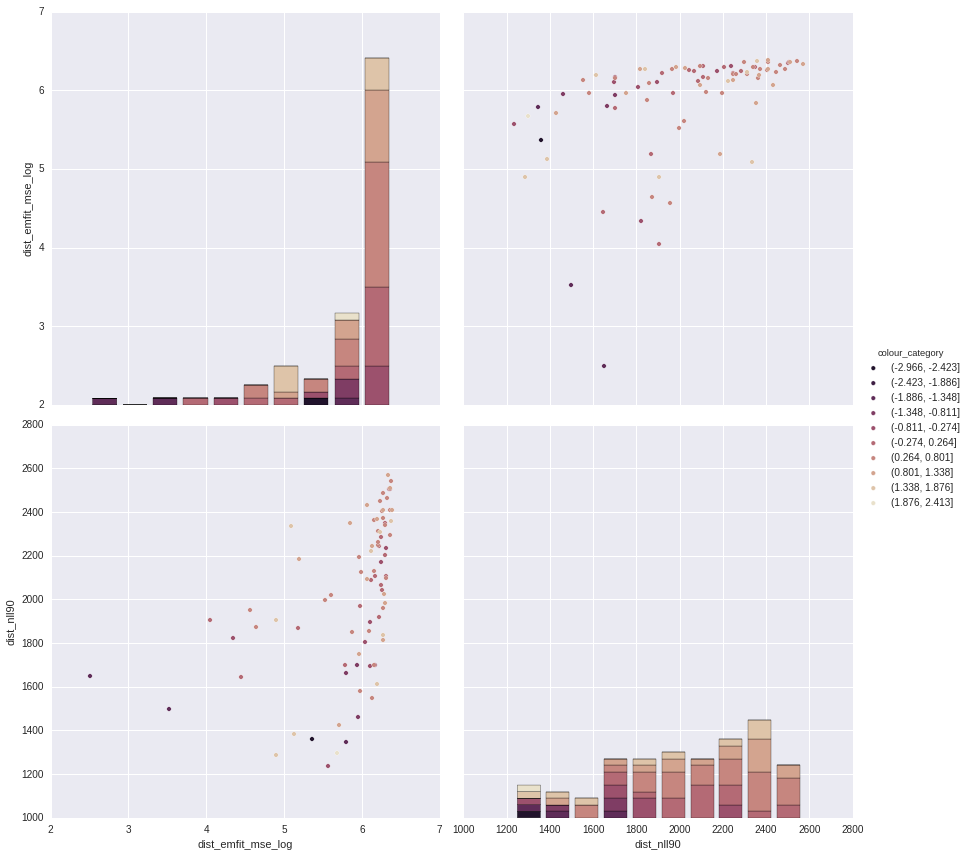

In [107]:
# Color code for Colour KL fit this time 
mycubehelix = sns.cubehelix_palette(dark=0.15, n_colors=10, start=0, rot=0.5, gamma=1.2, hue=0.9, light=0.9, reverse=True)
sns.pairplot(df_best_fits.assign(colour_category=pd.cut(np.log(df_best_fits['dist_emfit_kl']), bins=10)),
             hue='colour_category',
             palette=mycubehelix,
             vars=['dist_emfit_mse_log', 'dist_nll90'],
             size = 6
            )

## Plotly Scatter3d

In [108]:
import plotly
import plotly.plotly as py
import plotly.tools as tls
from plotly.graph_objs import * 

In [109]:
from IPython.html import widgets # Widget definitions
from IPython.display import display # Used to display widgets in the notebook
from plotly.widgets import GraphWidget 

In [110]:
sigmaoutput_gridified, sigmaoutput_gridspace, sigmaoutput_midspace = utils.gridify(df_best_fits.sigma_output, bins=10)

result_to_color = np.array(df_best_fits.dist_nll90)

col_min = np.min(result_to_color)
col_max = np.max(result_to_color)

text = ['%s > %s' % (x[0], x[1]) for x in zip(df_best_fits.sigma_output, result_to_color)]

trace1 = Scatter3d(
        x= df_best_fits.M,
        y= df_best_fits.ratio_conj,
        z= df_best_fits.sigmax,
        text= text,
        mode= 'markers',
        marker= Marker(
            color = result_to_color,
            size = 5,
            colorscale='Bluered',
            cmin=col_min,
            cmax=col_max,
            cauto=False
        )
    )
data = Data([trace1])
layout = Layout(
    scene=Scene(
        xaxis=XAxis(
            title=df_best_fits.columns.values[0],
        ),
        yaxis=YAxis(
            title=df_best_fits.columns.values[1],
        ),
        zaxis=ZAxis(
            title=df_best_fits.columns.values[2],
        )
    )
)
fig = Figure(data=data, layout=layout)
scatter3d_url = py.plot(fig)

In [111]:
g = GraphWidget(scatter3d_url)

class shifter:
    def __init__(self):
        self.sigmaoutput_index = 0
        self.marker_size = 10
        self.filter_results = slice(None, None)
    
    def on_sigmaoutput_change(self, name, old_value, new_value):
        self.sigmaoutput_index = new_value
        
        if self.sigmaoutput_index > -1:
            self.filter_results = sigmaoutput_gridified[self.sigmaoutput_index]
            self.marker_size = 10
        else:
            self.filter_results = slice(None, None)
            self.marker_size = 7
        
        self.text = ['%s > %s' % (x[0], x[1]) for x in 
                     zip(df_best_fits.sigma_output[self.filter_results], result_to_color[self.filter_results])]
        self.replot()
        
    def replot(self):
        new_trace = Scatter3d(
            x= df_best_fits.M[self.filter_results],
            y= df_best_fits.ratio_conj[self.filter_results],
            z= df_best_fits.sigmax[self.filter_results],
            text= self.text,
            mode= 'markers',
            marker= Marker(
                color = result_to_color[self.filter_results],
                size = self.marker_size,
                colorscale='Bluered',
                cmin=col_min,
                cmax=col_max,
                cauto=False
            )
        )
        g.restyle({'x': [[]], 'y': [[]], 'z': [[]], 'marker':None})
        g.add_traces(new_trace)

p_slider = widgets.IntSlider(min=-1, max=sigmaoutput_midspace.size-1, value=-1)
p_slider.description = 'Sigma_output index'

p_state = shifter()
p_slider.on_trait_change(p_state.on_sigmaoutput_change, 'value')
 

In [112]:
display(p_slider)
display(g)

## Look at best parameters


In [113]:
max_best_params = 10
print 'EM MSE'
print '\n'.join([str_best_params(best_ind, result_dist_emfit_mse) for best_ind in best_params_em[:max_best_params]])

print
print 'EM KL'
print '\n'.join([str_best_params(best_ind, result_dist_emfit_kl) for best_ind in best_params_kl[:max_best_params]])

print
print 'LL'
print '\n'.join([str_best_params(best_ind, result_dist_nll) for best_ind in best_params_ll[:max_best_params]])

print
print 'LL90'
print '\n'.join([str_best_params(best_ind, result_dist_nll90) for best_ind in best_params_ll90[:max_best_params]])

EM MSE
[337] M 254.0000 ratio_conj 0.7717 sigmax 0.3764 sigma_output 0.0754 >> 12.178680
[247] M 595.0000 ratio_conj 0.4857 sigmax 0.2674 sigma_output 0.2632 >> 33.812636
[236] M 470.0000 ratio_conj 0.6894 sigmax 0.5468 sigma_output 0.1425 >> 56.983587
[333] M 528.0000 ratio_conj 0.9167 sigmax 0.6391 sigma_output 0.0665 >> 62.650339
[241] M 274.0000 ratio_conj 0.7153 sigmax 0.5212 sigma_output 0.1206 >> 76.601981
[376] M 135.0000 ratio_conj 0.3630 sigmax 0.3125 sigma_output 0.2427 >> 85.504491
[  5] M 384.0000 ratio_conj 0.5104 sigmax 0.6029 sigma_output 0.1889 >> 96.077465
[242] M 343.0000 ratio_conj 0.0729 sigmax 0.0517 sigma_output 0.3016 >> 98.117017
[357] M 617.0000 ratio_conj 0.8574 sigmax 0.4922 sigma_output 0.1205 >> 98.674083
[312] M 232.0000 ratio_conj 0.4310 sigmax 0.4813 sigma_output 0.2618 >> 103.662116

EM KL
[191] M 574.0000 ratio_conj 0.5645 sigmax 0.3596 sigma_output 0.3931 >> 0.051791
[337] M 254.0000 ratio_conj 0.7717 sigmax 0.3764 sigma_output 0.0754 >> 0.173405
[24

# Observations

I think that the LL requires too high Sigma_output in order to get likely samples.
This corresponds to what I saw before, most points are too unlikely with a very flat sampling posterior, and sigma_output alleviates that.

It's flagrant with the correlation between sigma_output and emfit_MSE, where having sigma_output too high will destroy the fit of Kappas.

Hence we really need to move to another likelihood function, not with sigma_output, but with a baseline lapse rate. This should provide a small amount of support everywhere, without interacting with kappa at all.
Let's hope that will work.

It's unclear if starting CMA/ES runs will be useful or not.